In [ ]:
import os
import pandas as pd

# File paths for datasets
bar_data_path = "./merged_data.csv"
scan_data_dir = "./drive-download-20250114T131935Z-001"
weather_data_path = "./Weerdata Amsterdam 2022 - 2024.xlsx"

# 1. Load Bar Data
print("Loading bar data...")
df_bar = pd.read_csv(bar_data_path, low_memory=False)
df_bar["Datum"] = pd.to_datetime(df_bar["Datum"], errors="coerce", dayfirst=True)  # Parse datetime
df_bar["Date"] = df_bar["Datum"].dt.date
df_bar["Hour"] = df_bar["Datum"].dt.hour
print(f"Bar data loaded. Shape: {df_bar.shape}")

# 2. Load Ticket Data
print("\nLoading ticket data...")
# List all .xlsx files in the ticket data directory
scan_files = [os.path.join(scan_data_dir, f) for f in os.listdir(scan_data_dir) if f.endswith(".xlsx")]

# Combine all Excel files into a single DataFrame
df_scan_list = []
for file in scan_files:
    print(f"Loading file: {file}")
    df_temp = pd.read_excel(file)
    df_scan_list.append(df_temp)

# Concatenate all ticket data into one DataFrame
df_scan = pd.concat(df_scan_list, ignore_index=True)
df_scan["first_scanned_at"] = pd.to_datetime(df_scan["first_scanned_at"], errors="coerce")
df_scan["Date"] = df_scan["first_scanned_at"].dt.date
df_scan["Hour"] = df_scan["first_scanned_at"].dt.hour
print(f"Ticket data loaded. Shape: {df_scan.shape}")

# 3. Load Weather Data (Single XLSX File)
print("\nLoading weather data...")
df_weather = pd.read_excel(weather_data_path)
df_weather["Datum"] = pd.to_datetime(df_weather["Datum"], errors="coerce", dayfirst=True)
df_weather["Date"] = df_weather["Datum"].dt.date
print(f"Weather data loaded. Shape: {df_weather.shape}")

# Inspect the Loaded DataFrames
print("\nSample of Bar Data:")
print(df_bar.head())

print("\nSample of Ticket Data:")
print(df_scan.head())

print("\nSample of Weather Data:")
print(df_weather.head())


Loading bar data...
Bar data loaded. Shape: (1349308, 28)

Loading ticket data...
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/No Art ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/Multigroove ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/Everyday PPL ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/HMC ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/VBX ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/Sounds Familiar ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/Misc ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-20250114T131935Z-001/Radio Radio ticket data.xlsx
Loading file: /Users/wybehempenius/Downloads/drive-download-2

In [193]:
import itertools

# 1. Aggregate Bar Data (Hourly Revenue)
bar_hourly = (
    df_bar.groupby(["Date", "Hour", "Virtuele terminalnaam"], as_index=False)["Aantal * prijs"]
    .sum()
    .rename(columns={"Aantal * prijs": "BarRevenue"})
)
print(f"Bar data aggregated to hourly level. Shape: {bar_hourly.shape}")

# 2. Aggregate Ticket Data (Hourly Ticket Counts)
scan_hourly = (
    df_scan.groupby(["Date", "Hour"], as_index=False)
    .size()
    .rename(columns={"size": "TicketScans"})
)
print(f"Ticket data aggregated to hourly level. Shape: {scan_hourly.shape}")

# 3. Prepare Weather Data (Hourly Weather)
# Create all combinations of Date and Hour (0-23) to replicate daily weather for each hour
dates = df_weather["Date"].unique()
hours = range(24)
all_date_hour = pd.DataFrame(itertools.product(dates, hours), columns=["Date", "Hour"])

# Merge weather data with all_date_hour to duplicate daily data for each hour
weather_hourly = pd.merge(all_date_hour, df_weather, on="Date", how="left")
print(f"Weather data replicated to hourly level. Shape: {weather_hourly.shape}")

# 4. Merge All Datasets
# Merge bar data and ticket data
df_merged = pd.merge(
    bar_hourly,
    scan_hourly,
    on=["Date", "Hour"],
    how="outer"  
)

# Merge with weather data
df_merged = pd.merge(
    df_merged,
    weather_hourly,
    on=["Date", "Hour"],
    how="left"  
)

# Fill missing ticket counts and weather data (if necessary)
df_merged["TicketScans"].fillna(0, inplace=True)
df_merged.fillna(0, inplace=True)  # Optionally fill other NaNs with 0
print(f"Final merged dataset shape: {df_merged.shape}")




Bar data aggregated to hourly level. Shape: (20754, 4)
Ticket data aggregated to hourly level. Shape: (2088, 3)
Weather data replicated to hourly level. Shape: (21768, 8)
Final merged dataset shape: (21108, 11)


/var/folders/3j/6377wsj96xb_ykwxmrcmv0800000gn/T/ipykernel_76040/118858945.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_merged.fillna(0, inplace=True)  # Optionally fill other NaNs with 0


In [194]:
# Show sample rows and column info
print(df_merged.head())
print(df_merged.info())


         Date  Hour Virtuele terminalnaam  BarRevenue  TicketScans  \
0  2022-07-01  20.0          Grote bar 10         3.5          0.0   
1  2022-07-02  12.0           Grote bar 2        30.8          0.0   
2  2022-07-02  13.0           Buitenbar 1        33.6          0.0   
3  2022-07-02  13.0           Grote bar 2         9.0          0.0   
4  2022-07-02  13.0           grote bar 7        12.8          0.0   

                 Datum     Tmax     Tmin Neerslag Max Windstoot Opmerkingen  
0  2022-07-01 00:00:00  20.3 °C  13.7 °C   1,4 mm     29.0 km/u           0  
1  2022-07-02 00:00:00  23.6 °C  14.2 °C   0,0 mm     20.9 km/u           0  
2  2022-07-02 00:00:00  23.6 °C  14.2 °C   0,0 mm     20.9 km/u           0  
3  2022-07-02 00:00:00  23.6 °C  14.2 °C   0,0 mm     20.9 km/u           0  
4  2022-07-02 00:00:00  23.6 °C  14.2 °C   0,0 mm     20.9 km/u           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21108 entries, 0 to 21107
Data columns (total 11 columns):
 #

In [195]:
# Fix 1: Convert Hour to Integer
df_merged["Hour"] = df_merged["Hour"].astype(int)

# Fix 2: Clean Tmax, Tmin, Neerslag
# Remove units and commas, then convert to numeric
df_merged["Tmax"] = df_merged["Tmax"].str.replace(" °C", "", regex=False).str.replace(",", ".").astype(float)
df_merged["Tmin"] = df_merged["Tmin"].str.replace(" °C", "", regex=False).str.replace(",", ".").astype(float)
df_merged["Neerslag"] = df_merged["Neerslag"].str.replace(" mm", "", regex=False).str.replace(",", ".").astype(float)

# Fix 3: Drop Duplicate Date Column
df_merged.drop(columns=["Datum"], inplace=True)

# Fix 4: Standardize Virtuele terminalnaam
df_merged["Virtuele terminalnaam"] = df_merged["Virtuele terminalnaam"].str.strip().str.lower()

# Inspect the cleaned dataset
print(df_merged.head())
print(df_merged.info())


         Date  Hour Virtuele terminalnaam  BarRevenue  TicketScans  Tmax  \
0  2022-07-01    20          grote bar 10         3.5          0.0  20.3   
1  2022-07-02    12           grote bar 2        30.8          0.0  23.6   
2  2022-07-02    13           buitenbar 1        33.6          0.0  23.6   
3  2022-07-02    13           grote bar 2         9.0          0.0  23.6   
4  2022-07-02    13           grote bar 7        12.8          0.0  23.6   

   Tmin  Neerslag Max Windstoot Opmerkingen  
0  13.7       1.4     29.0 km/u           0  
1  14.2       0.0     20.9 km/u           0  
2  14.2       0.0     20.9 km/u           0  
3  14.2       0.0     20.9 km/u           0  
4  14.2       0.0     20.9 km/u           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21108 entries, 0 to 21107
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   21108 non-null  object 
 1

In [196]:
output_path = "/Users/wybehempenius/Downloads/merged_hourly_dataset1.csv"
df_merged.to_csv(output_path, index=False)
print(f"Merged dataset saved to: {output_path}")


Merged dataset saved to: /Users/wybehempenius/Downloads/merged_hourly_dataset1.csv


In [197]:
# 1. Handle Missing Values in Virtuele terminalnaam
# Option: Drop rows with missing bar names (if they can't be resolved)
df_merged = df_merged.dropna(subset=["Virtuele terminalnaam"])

# 2. Handle Missing Weather Data
# Fill missing Tmax and Tmin with their median
df_merged["Tmax"].fillna(df_merged["Tmax"].median(), inplace=True)
df_merged["Tmin"].fillna(df_merged["Tmin"].median(), inplace=True)

# 3. Clean Max Windstoot
df_merged["Max Windstoot"] = (
    df_merged["Max Windstoot"]
    .str.replace(" km/u", "", regex=False)  # Remove units
    .str.replace(",", ".")  # Convert to decimal format
    .astype(float)
)

# 4. Final Check
print(f"After cleaning, dataset shape: {df_merged.shape}")
print(df_merged.info())


After cleaning, dataset shape: (20754, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 20754 entries, 0 to 20753
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   20754 non-null  object 
 1   Hour                   20754 non-null  int64  
 2   Virtuele terminalnaam  20754 non-null  object 
 3   BarRevenue             20754 non-null  float64
 4   TicketScans            20754 non-null  float64
 5   Tmax                   20754 non-null  float64
 6   Tmin                   20754 non-null  float64
 7   Neerslag               20666 non-null  float64
 8   Max Windstoot          20666 non-null  float64
 9   Opmerkingen            20754 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 1.7+ MB
None


In [198]:
# Filter for rows corresponding to Artiesten bar
artiesten_data = df_merged[df_merged["Virtuele terminalnaam"] == "artiesten"]
print(artiesten_data[["Date", "Hour", "BarRevenue", "TicketScans"]].sort_values(by="BarRevenue", ascending=False).head(10))

# Check total revenue for the bar
total_revenue_artiesten = artiesten_data["BarRevenue"].sum()
print(f"Total revenue for Artiesten bar: €{total_revenue_artiesten:.2f}")


             Date  Hour  BarRevenue  TicketScans
18604  2024-09-22    20     5181.05          0.0
19773  2024-11-07    18     4416.70          0.0
18610  2024-09-26    21     4126.90          0.0
18609  2024-09-26    19     2439.80          0.0
18611  2024-09-26    22     2206.10          0.0
18031  2024-09-05    19     1558.15          0.0
19777  2024-11-07    19     1413.05          0.0
18035  2024-09-05    22     1214.20          0.0
18029  2024-09-05    18     1165.35          0.0
18033  2024-09-05    20     1151.00          0.0
Total revenue for Artiesten bar: €43711.46


In [199]:
# Filter for rows where Hour = 10
hour_10_data = df_merged[df_merged["Hour"] == 10]
print(hour_10_data[["Date", "Virtuele terminalnaam", "BarRevenue", "TicketScans"]].sort_values(by="BarRevenue", ascending=False).head(10))

# Aggregate revenue at 10 AM by bar
hour_10_by_bar = hour_10_data.groupby("Virtuele terminalnaam")["BarRevenue"].sum()
print(hour_10_by_bar.sort_values(ascending=False))


             Date Virtuele terminalnaam  BarRevenue  TicketScans
20588  2024-12-16       stagemanagement    23489.95          0.0
18787  2024-10-04           grote bar 1    13141.30          0.0
20592  2024-12-18           grote bar 1    11552.90          0.0
9218   2023-11-03           grote bar 1     2529.10          0.0
10068  2023-12-17       stagemanagement     1344.00          0.0
10067  2023-12-16       stagemanagement      899.50          0.0
17463  2024-08-18           buitenbar 5      574.25         24.0
16275  2024-07-21           grote bar 3      567.15          7.0
12204  2024-04-12           grote bar 7      519.15          0.0
12793  2024-04-29       stagemanagement      496.00          0.0
Virtuele terminalnaam
grote bar 1        27387.75
stagemanagement    26928.25
grote bar 2          719.65
grote bar 3          715.35
buitenbar 5          574.26
grote bar 7          522.40
deur                 397.50
artiesten            357.45
buitenbar 8          321.07
coktailbar 

In [200]:
df_merged = df_merged[(df_merged["BarRevenue"] >= 0) & (df_merged["BarRevenue"] <= 2000)]


In [201]:
# Filter data for Artiesten
artiesten_data = df_merged[df_merged["Virtuele terminalnaam"] == "artiesten"]

# Summary statistics for Artiesten
print(artiesten_data["BarRevenue"].describe())

# Inspect the top revenue rows for Artiesten
print(artiesten_data.sort_values(by="BarRevenue", ascending=False).head(10))


count      59.000000
mean      429.506949
std       423.096651
min         0.010000
25%        23.225000
50%       341.750000
75%       691.250000
max      1558.150000
Name: BarRevenue, dtype: float64
             Date  Hour Virtuele terminalnaam  BarRevenue  TicketScans  Tmax  \
18031  2024-09-05    19             artiesten     1558.15          0.0  29.6   
19777  2024-11-07    19             artiesten     1413.05          0.0  10.0   
18035  2024-09-05    22             artiesten     1214.20          0.0  29.6   
18029  2024-09-05    18             artiesten     1165.35          0.0  29.6   
18033  2024-09-05    20             artiesten     1151.00          0.0  29.6   
18053  2024-09-06    23             artiesten     1147.20          0.0  29.2   
18034  2024-09-05    21             artiesten     1105.55          0.0  29.6   
15333  2024-06-28    16             artiesten     1101.40          0.0  19.8   
18605  2024-09-22    21             artiesten      975.65          0.0  25.7   

In [202]:
# Compare the number of rows and total revenue for all bars
bar_stats = df_merged.groupby("Virtuele terminalnaam")["BarRevenue"].agg(["count", "sum", "mean"]).sort_values(by="mean", ascending=False)
print(bar_stats)


                       count        sum        mean
Virtuele terminalnaam                              
buitenbar 9              569  288380.69  506.820193
buitenbar 1             1333  646069.90  484.673593
grote bar 8             1022  441424.48  431.922192
artiesten                 59   25340.91  429.506949
buitenbar 4              668  275220.01  412.006003
buitenbar 8              381  156337.77  410.335354
buitenbar 3              760  307799.02  404.998711
buitenbar 2             1008  394455.72  391.325119
grote bar 9             1145  440661.07  384.856830
buitenbar 5              700  266579.90  380.828429
grote bar 5              994  365241.25  367.445926
grote bar 6             1093  387502.46  354.531070
buitenbar 6              633  224186.98  354.165845
buitenbar 7              438  153495.18  350.445616
grote bar 2             1212  421341.28  347.641320
grote bar 7              703  236787.72  336.824637
grote bar 11             674  226011.33  335.328383
grote bar 4 

In [203]:
df_merged = df_merged[df_merged["Virtuele terminalnaam"] != "artiesten"]


               Hour    BarRevenue   TicketScans          Tmax          Tmin  \
count  20601.000000  20601.000000  20601.000000  20601.000000  20601.000000   
mean      12.599971    345.262399     99.799913     18.367856     11.290869   
std        8.532441    306.334019    148.318104      6.376640      4.640530   
min        0.000000      0.000000      0.000000      0.400000     -5.000000   
25%        3.000000     90.450000      0.000000     14.200000      7.800000   
50%       16.000000    286.550000     43.000000     18.400000     12.000000   
75%       20.000000    517.450000    138.000000     22.900000     14.600000   
max       23.000000   1999.350000   1132.000000     38.200000     21.600000   

           Neerslag  Max Windstoot  
count  20513.000000   20513.000000  
mean       3.600692      28.724584  
std        7.488693      10.876913  
min        0.000000       6.400000  
25%        0.000000      20.900000  
50%        0.400000      27.400000  
75%        4.200000      33.8

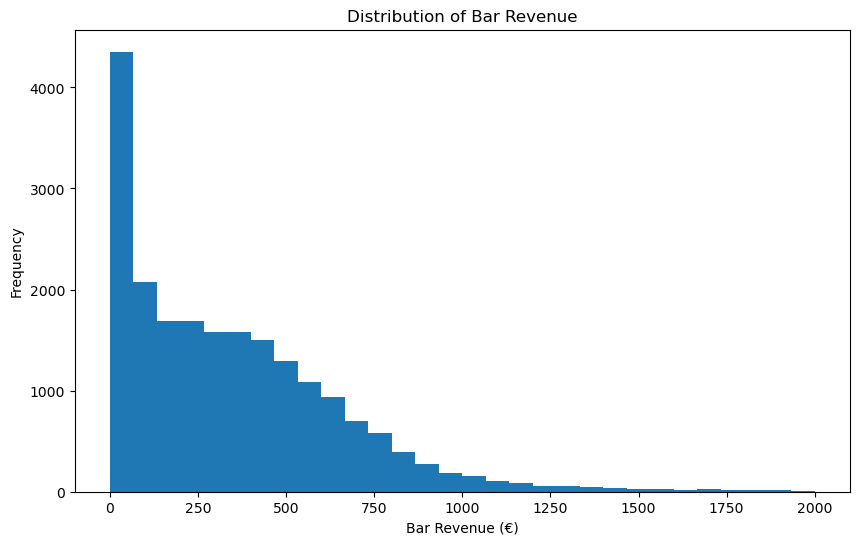

Correlation Matrix:
               BarRevenue  TicketScans      Tmax      Tmin  Neerslag  \
BarRevenue       1.000000     0.190087 -0.005650 -0.016682  0.004082   
TicketScans      0.190087     1.000000 -0.065409 -0.066849  0.010890   
Tmax            -0.005650    -0.065409  1.000000  0.858438 -0.219164   
Tmin            -0.016682    -0.066849  0.858438  1.000000 -0.127961   
Neerslag         0.004082     0.010890 -0.219164 -0.127961  1.000000   
Max Windstoot    0.000969     0.022120 -0.346298 -0.145767  0.355706   

               Max Windstoot  
BarRevenue          0.000969  
TicketScans         0.022120  
Tmax               -0.346298  
Tmin               -0.145767  
Neerslag            0.355706  
Max Windstoot       1.000000  


In [204]:
import matplotlib.pyplot as plt


# Summary statistics for numeric columns
print(df_merged.describe())

# Distribution of BarRevenue
df_merged["BarRevenue"].plot(kind="hist", bins=30, title="Distribution of Bar Revenue", figsize=(10, 6))
plt.xlabel("Bar Revenue (€)")
plt.show()

# Check correlation between numeric features
correlation_matrix = df_merged[["BarRevenue", "TicketScans", "Tmax", "Tmin", "Neerslag", "Max Windstoot"]].corr()
print("Correlation Matrix:")
print(correlation_matrix)


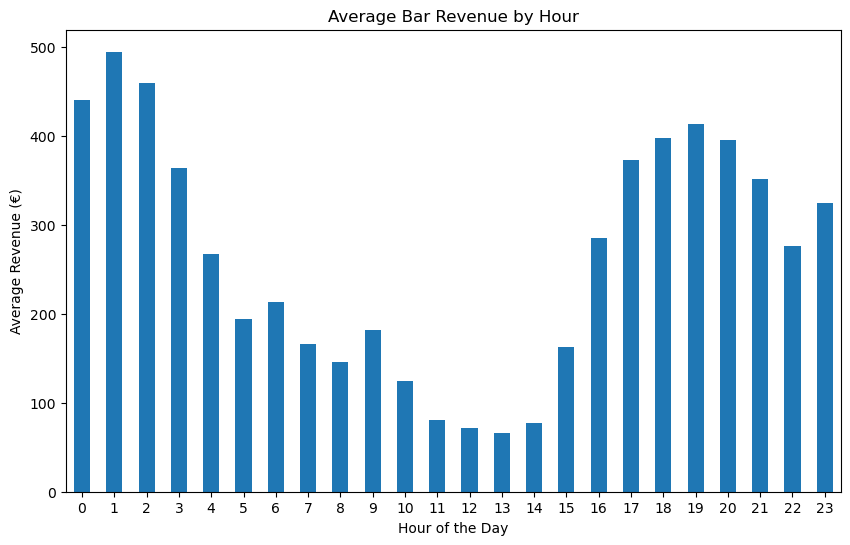

In [205]:
# Average BarRevenue by Hour
revenue_by_hour = df_merged.groupby("Hour")["BarRevenue"].mean()

# Plot
revenue_by_hour.plot(kind="bar", figsize=(10, 6), title="Average Bar Revenue by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Revenue (€)")
plt.xticks(rotation=0)
plt.show()


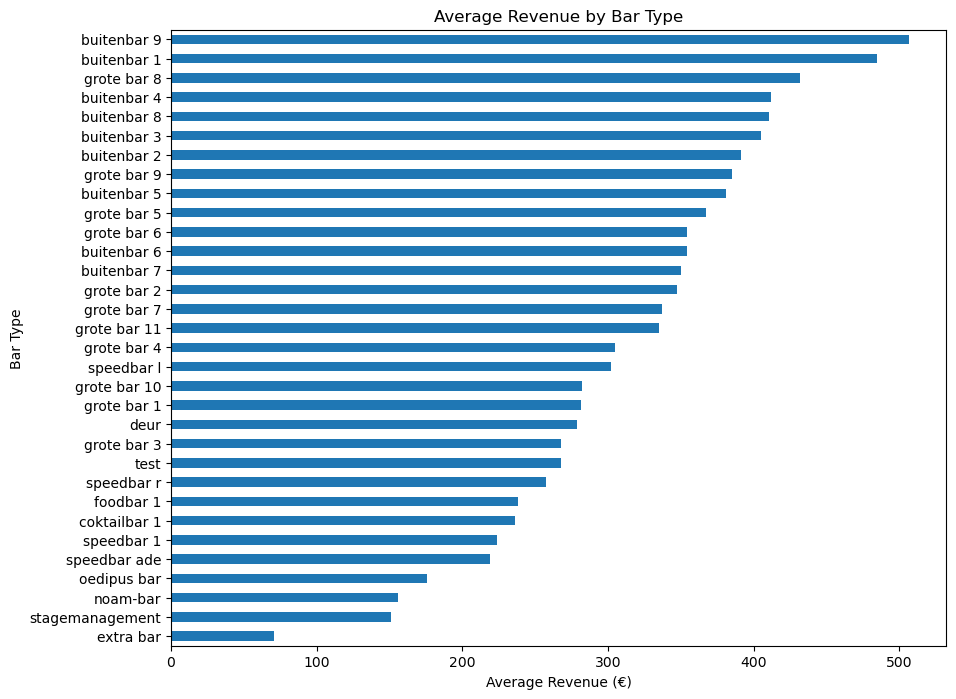

In [206]:
# Average revenue per bar
revenue_by_bar = df_merged.groupby("Virtuele terminalnaam")["BarRevenue"].mean()

# Plot
revenue_by_bar.sort_values().plot(kind="barh", figsize=(10, 8), title="Average Revenue by Bar Type")
plt.xlabel("Average Revenue (€)")
plt.ylabel("Bar Type")
plt.show()


Correlation between Neerslag and BarRevenue:
            Neerslag  BarRevenue
Neerslag    1.000000    0.004082
BarRevenue  0.004082    1.000000


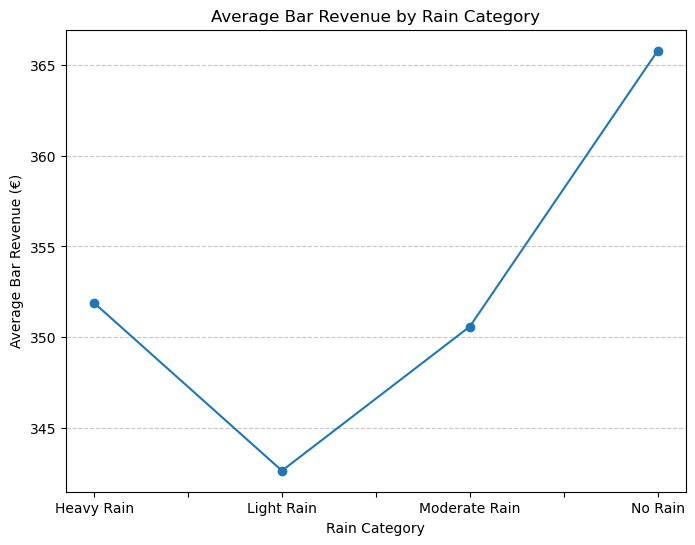

In [207]:
import seaborn as sns

# Step 1: Correlation between Neerslag and BarRevenue
correlation = df_merged[["Neerslag", "BarRevenue"]].corr()
print("Correlation between Neerslag and BarRevenue:")
print(correlation)

# Step 2: Group by precipitation levels
def categorize_precipitation(neerslag):
    if neerslag == 0:
        return "No Rain"
    elif neerslag <= 2:
        return "Light Rain"
    elif neerslag <= 10:
        return "Moderate Rain"
    else:
        return "Heavy Rain"

df_merged["RainCategory"] = df_merged["Neerslag"].apply(categorize_precipitation)

rain_revenue.plot(kind="line", marker="o", figsize=(8, 6))
plt.title("Average Bar Revenue by Rain Category")
plt.xlabel("Rain Category")
plt.ylabel("Average Bar Revenue (€)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Average Revenue by Hour:
Hour
0     440.124812
1     494.981055
2     460.093572
3     364.167832
4     267.808234
5     194.494570
6     213.795582
7     166.279669
8     145.657143
9     182.373125
10    124.172462
11     80.946125
12     72.235826
13     65.646798
14     77.847041
15    162.776052
16    285.234518
17    372.676653
18    397.393018
19    413.451418
20    395.903592
21    351.859929
22    276.603773
23    324.838727
Name: BarRevenue, dtype: float64


/var/folders/3j/6377wsj96xb_ykwxmrcmv0800000gn/T/ipykernel_76040/635781364.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_top_bars, x="Hour", y="BarRevenue", hue="Virtuele terminalnaam", ci=None)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


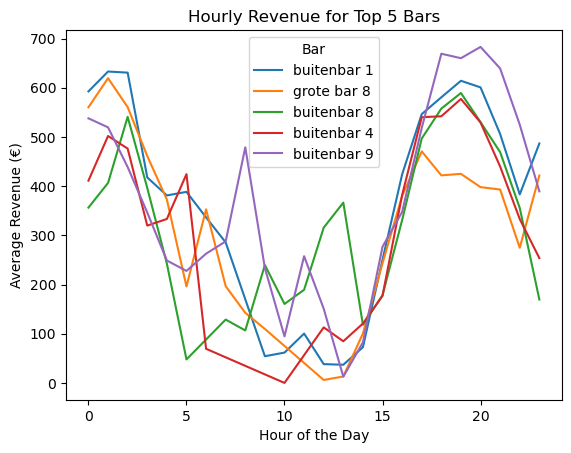

In [208]:
# Step 1: Average revenue by hour
hourly_revenue = df_merged.groupby("Hour")["BarRevenue"].mean()
print("Average Revenue by Hour:")
print(hourly_revenue)

# Step 2: Visualize hourly performance for top-performing bars
top_bars = df_merged.groupby("Virtuele terminalnaam")["BarRevenue"].mean().sort_values(ascending=False).head(5).index
df_top_bars = df_merged[df_merged["Virtuele terminalnaam"].isin(top_bars)]

sns.lineplot(data=df_top_bars, x="Hour", y="BarRevenue", hue="Virtuele terminalnaam", ci=None)
plt.title("Hourly Revenue for Top 5 Bars")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Revenue (€)")
plt.legend(title="Bar")
plt.show()


In [223]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Add StaffNeeded if predicting staff
df_merged["StaffNeeded"] = df_merged["BarRevenue"].apply(lambda x: math.ceil(x / 330))

# Check and fix missing values
numeric_cols = ["Hour", "TicketScans", "Tmax", "Tmin", "Neerslag", "Max Windstoot"]
df_merged[numeric_cols] = df_merged[numeric_cols].fillna(df_merged[numeric_cols].median())
df_merged["Virtuele terminalnaam"] = df_merged["Virtuele terminalnaam"].fillna("unknown")

# Ensure correct data types
df_merged["Hour"] = df_merged["Hour"].astype(int)
df_merged["Virtuele terminalnaam"] = df_merged["Virtuele terminalnaam"].astype(str)

# Define features (X) and target (y)
X = df_merged[["Hour", "TicketScans", "Tmax", "Tmin", "Neerslag", "Max Windstoot", "Virtuele terminalnaam"]]
y = df_merged["BarRevenue"]  # Or df_merged["StaffNeeded"] for staffing predictions

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline: One-hot encode categorical features
categorical_features = ["Virtuele terminalnaam"]
numeric_features = numeric_cols

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Hour', 'TicketScans',
                                                   'Tmax', 'Tmin', 'Neerslag',
                                                   'Max Windstoot']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Virtuele terminalnaam'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [210]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Absolute Error (MAE): €{mae:.2f}")
print(f"R² Score: {r2:.2f}")


Model Performance:
Mean Absolute Error (MAE): €162.73
R² Score: 0.43


In [214]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Create a pipeline with GradientBoostingRegressor
gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    "model__n_estimators": [50, 200, 800],
    "model__learning_rate": [0.01, 0.05, 0.3],
    "model__max_depth": [3, 6, 7],
    "model__min_samples_split": [5, 20]
}

# Grid search
grid_search = GridSearchCV(
    gb_pipeline,
    param_grid,
    cv=10,
    scoring="r2",
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Evaluate the best Gradient Boosting model
best_gb_model = grid_search.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)

# Metrics
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

print("Best Parameters for Gradient Boosting:", grid_search.best_params_)
print(f"Gradient Boosting MAE: €{gb_mae:.2f}")
print(f"Gradient Boosting R² Score: {gb_r2:.2f}")


Best Parameters for Gradient Boosting: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_samples_split': 5, 'model__n_estimators': 800}
Gradient Boosting MAE: €149.91
Gradient Boosting R² Score: 0.52


In [224]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Randomized search with fewer parameter combinations
random_search_gb = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=param_grid_gb,
    n_iter=20,       
    cv=3,            
    scoring="r2",   
    n_jobs=-1,      
    random_state=42 
)

random_search_gb.fit(X_train, y_train)

# Evaluate the best model
best_gb_model = random_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

print("Best Parameters for Gradient Boosting (Randomized Search):", random_search_gb.best_params_)
print(f"Randomized Gradient Boosting MAE: €{gb_mae:.2f}")
print(f"Randomized Gradient Boosting R² Score: {gb_r2:.2f}")


Best Parameters for Gradient Boosting (Randomized Search): {'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 10, 'model__learning_rate': 0.1}
Randomized Gradient Boosting MAE: €143.98
Randomized Gradient Boosting R² Score: 0.55
